In [ ]:
%pip install tqdm
%pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00


In [ ]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint

In [ ]:
wandb.login(key=)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'latent_dim': {
        'value':10},
    'num_epochs':{
        'value':20},
    'batch_size':{
        'value':16},
    'learning_rate':{
        'value':3.5e-4},
    'alpha':{
        'value':0},
    'lbd':{
        'value':1000},
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='MNIST 7 layer untuned')
project='MNIST 7 layer untuned'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: xq2a46jj
Sweep URL: https://wandb.ai/t-a-emm-20/MNIST%207%20layer%20untuned/sweeps/xq2a46jj


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6046433.38it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156101.89it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1502777.75it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9320219.55it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

torch.Size([50000, 1, 28, 28])


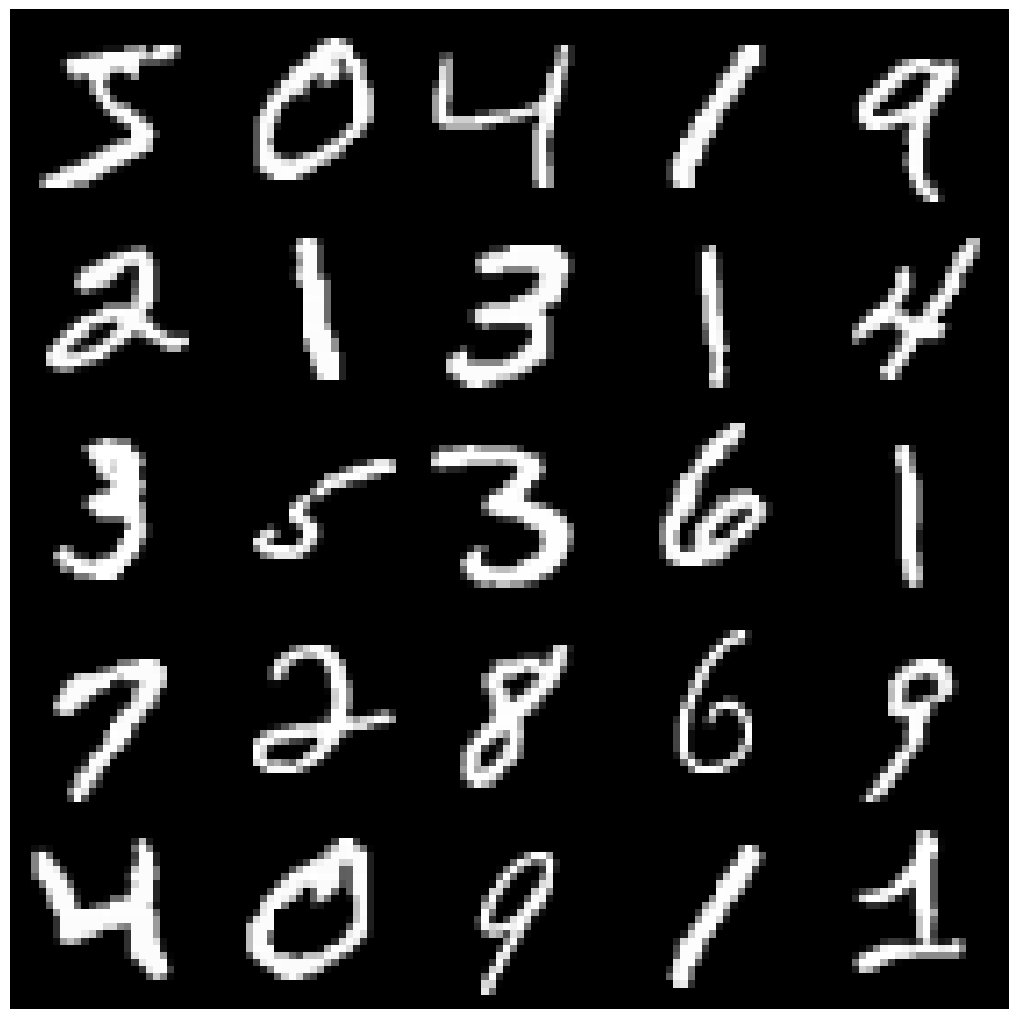

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

print(train_dataset.shape)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
      super().__init__()
      #encoding
      self.in_lay=nn.Linear(input_dim,1600)
      self.enclay1=nn.Linear(1600,800)
      self.mu=nn.Linear(800,latent_dim)
      self.logstd=nn.Linear(800,latent_dim)

      #deocoding
      self.declay1=nn.Linear(latent_dim,800)
      self.declay2=nn.Linear(800,1600)
      self.out_lay=nn.Linear(1600,input_dim)

      self.relu=nn.ReLU()

    def encode(self,x):
        el1=self.relu(self.in_lay(x))
        el2=self.relu(self.enclay1(el1))
        mu=self.mu(el2)
        logstd=self.logstd(el2)

        return mu, logstd

    def decode(self, z):
        dl1=self.relu(self.declay1(z))
        dl2=self.relu(self.declay2(dl1))

        return torch.sigmoid(self.out_lay(dl2))

    def forward(self,x):
        mu, logstd = self.encode(x)
        std=torch.exp(logstd)
        eps = torch.randn_like(logstd)
        z_reparam = mu + std*eps
        z_prior = torch.randn_like(logstd)
        x_recon = self.decode(z_reparam)

        return x_recon, mu, logstd, z_prior, z_reparam

In [ ]:
def loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior):
    recon_loss=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='sum')
    kl_div = -0.5*torch.sum(1+logstd-mu.pow(2)-(torch.exp(logstd)).pow(2))

    def imq_kernel(z1,z2):
        Cbase = (2* latent_dim * kernel_bandwidth**2)
        k =0
        for scale in scales:
            C=scale*Cbase

            k+= C/(C + torch.norm(z1.unsqueeze(1)-z2.unsqueeze(0),dim=-1) ** 2)
        return k

    k_z=imq_kernel(z_reparam,z_reparam)
    k_z_prior=imq_kernel(z_prior,z_prior)
    k_cross=imq_kernel(z_reparam,z_prior)

    mmd_z=(k_z - k_z.diag().diag()).sum()/((n-1)*n)
    mmd_z_prior=(k_z_prior-k_z_prior.diag().diag()).sum()/((n-1)*n)
    mmd_cross=k_cross.sum()/(n**2)
    mmd_loss=mmd_z+mmd_z_prior-2*mmd_cross

    return recon_loss, kl_div, mmd_loss

In [ ]:
def train(config=None):
    wandb.init(config = config)
    config=wandb.config

    input_dim=784
    latent_dim=config.latent_dim
    num_epochs=config.num_epochs
    batch_size=config.batch_size
    learning_rate=config.learning_rate
    alpha=config.alpha
    lbd=config.lbd
    scales = [0.1, 0.2, 0.5, 1.0, 2.0, 5, 10.0]
    kernel_bandwidth=1

    #dataset
    train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
    model=VariationalAutoEncoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    z_star=[]

    #train
    for epoch in range(num_epochs):
        loop=tqdm(enumerate(train_loader))
        #batch_recon=[]
        #batch_kl_div=[]
        #batch_mmd=[]

        for i, x in loop:
            x=x.to(device).view(x.shape[0],input_dim)
            x_recon, mu, logstd, z_prior, z_reparam =model(x)
            n=z_reparam.shape[0]
            z_star.append(z_reparam.detach())
            #print(z_reparam)

            recon_loss, kl_div, mmd_loss=loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior)

            #batch_recon.append(recon_loss)
            #batch_kl_div.append(kl_div)
            #batch_mmd.append(mmd_loss)

        #epoch_recon=torch.mean(torch.stack(batch_recon))
        #epoch_kl_div=torch.mean(torch.stack(batch_kl_div))
        #epoch_mmd=torch.mean(torch.stack(batch_mmd))

            loss= recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            wandb.log({'loss':loss,'epoch':epoch,'recon loss':recon_loss,'kl diverg':kl_div,'mmd loss':mmd_loss})


    #Sample
    gen_imgs=[]
    num_samples=25
    full_batch_nbr=int(num_samples/batch_size)
    last_batch_nbr=num_samples % batch_size

    for i in range(num_samples):
        z_gen=torch.zeros(10)
        for j in range(latent_dim):
            z_gen[j]=torch.tensor(np.random.normal(loc=0, scale=1.1, size=1))
        #print(z_gen)
        z_gen=z_gen.to(device)
        x_gen=model.decode(z_gen).detach()
        gen_img=x_gen.reshape(1,28,28)
        gen_imgs.append(gen_img)
    gen_imgs=torch.stack(gen_imgs)


    #Plot
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i][j].imshow(gen_imgs[i*5 +j].cpu().squeeze(0), cmap='gray')
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)

    run_name=wandb.run.name
    run_gen='generated'
    run_gen_name=run_name+run_gen
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_gen_name}.png"
    plt.savefig(img_path)


    #Reconstruction
    to_recon=[]
    hi=[1,3,5,7,9,0,18,15,17,4]
    for i in range(10):
        to_recon.append(train_dataset[hi[i]])

    to_recon_imgs=torch.stack(to_recon)

    recond=[]
    rec_errors=[]
    for i in range(10):
        x=to_recon_imgs[i].to(device).view(1,input_dim)
        x_recon, mu, logstd, z_prior, z_reparam =model(x)
        recon_error=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='mean')
        x_recon_img=x_recon.reshape(1,28,28)
        recond.append(x_recon_img.detach())
        rec_errors.append(recon_error.detach())

    recond_imgs=torch.stack(recond)
    print(rec_errors)
    #wandb.log({'Digit Reconstruction Errors':rec_errors})

    fig3, axes3 = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
    for i in range(10):
        axes3[0][i].imshow(to_recon_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[0][i].axis('off')
        axes3[1][i].imshow(recond_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[1][i].axis('off')

    plt.tight_layout(pad=0.)

    plt.tight_layout(pad=0.)
    run_recon='recon'
    run_recon_name=run_name+run_recon
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_recon_name}.png"
    plt.savefig(img_path)

    #Disentanglment Metric
    fixed_metric=randint(0,9)
    num_tests=10
    zldiff=[]

    for j in range(num_tests):
        v1=torch.zeros(latent_dim)
        v2=torch.zeros(latent_dim)

        for i in range(latent_dim):
            v1[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            v2[i]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            t=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
            v1[fixed_metric]=t
            v2[fixed_metric]=t
            v1=v1.to(device)
            v2=v2.to(device)

        x1=model.decode(v1).detach()
        x1_img=x1.reshape(1,28,28)
        x2=model.decode(v2).detach()
        x2_img=x2.reshape(1,28,28)

        z1mu, z1logstd=model.encode(x1)
        z2mu, z2logstd=model.encode(x2)

        eps1=torch.randn_like(z1logstd)
        #std1=torch.exp(z1logstd)
        z1=z1mu+eps1*torch.exp(0.5*z1logstd)

        eps2=torch.randn_like(z2logstd)
        #std2=torch.exp(z2logstd)
        z2=z2mu+eps2*torch.exp(0.5*z2logstd)

        for i in range(len(z1)):
            zldiff.append(abs(z1[i]-z2[i]))

    zldiff=torch.stack(zldiff)
    zbdiff=(1/(num_tests*latent_dim))*torch.sum(zldiff)*100
    print(zbdiff)
    wandb.log({'zbdiff':zbdiff})

wandb: Agent Starting Run: van0sev1 with config:
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	lbd: 1000
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:52, 59.87it/s, loss=763]
3125it [00:54, 57.36it/s, loss=660]
3125it [00:53, 58.57it/s, loss=513]
3125it [00:54, 57.03it/s, loss=560]
3125it [00:53, 58.74it/s, loss=613]
3125it [00:54, 57.19it/s, loss=492]
3125it [00:55, 55.94it/s, loss=481]
3125it [00:55, 56.35it/s, loss=437]
3125it [00:52, 59.42it/s, loss=491]
3125it [00:53, 58.51it/s, loss=640]
3125it [00:53, 58.04it/s, loss=737]
3125it [00:53, 58.64it/s, loss=741]
3125it [00:54, 57.09it/s, loss=584]
3125it [00:54, 57.73it/s, loss=456]
3125it [00:53, 58.19it/s, loss=584]
3125it [00:53, 58.93it/s, loss=487]
3125it [00:55, 56.75it/s, loss=378]
3125it [00:53, 58.11it/s, loss=373]
3125it [00:53, 58.17it/s, loss=496]
3125it [00:53, 58.11it/s, loss=378]


[tensor(0.0199, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(0.0506, device='cuda:0'), tensor(0.0188, device='cuda:0'), tensor(0.0167, device='cuda:0'), tensor(0.0463, device='cuda:0'), tensor(0.0183, device='cuda:0'), tensor(0.0129, device='cuda:0'), tensor(0.0263, device='cuda:0'), tensor(0.0345, device='cuda:0')]
tensor(103.5483, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▂▃▅▅▆▆▆▆▇▇▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇█▇▇
loss,▇▆▄▃▄▄▄▃█▃▃▄▂▃▄▄▂▁▂▃▂▃▃▃▃▂▂▃▄▃▄▃▃▁▂▂▃▁▁▃
mmd loss,▃▄▃▂▄▃▄▃█▂▅▃▃▃▄▄▁▃▁▃▃▃▃▂▃▂▁▃▃▂▅▄▃▂▂▂▃▁▂▃
recon loss,█▆▅▃▃▄▄▃▄▃▂▄▂▃▃▃▃▁▃▂▂▃▄▄▃▂▃▃▄▄▂▁▃▂▂▃▃▂▂▃
zbdiff,▁
epoch,19
kl diverg,70.13286
loss,378.06772
mmd loss,-0.10515
recon loss,412.9823


wandb: Agent Starting Run: 4i0qhhl5 with config:
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	lbd: 1000
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:54, 57.42it/s, loss=721]
3125it [00:53, 58.37it/s, loss=735]
3125it [00:52, 59.07it/s, loss=628]
3125it [00:53, 58.64it/s, loss=598]
3125it [00:55, 56.55it/s, loss=516]
3125it [00:53, 58.70it/s, loss=487]
3125it [00:52, 58.98it/s, loss=519]
3125it [00:53, 58.05it/s, loss=517]
3125it [00:54, 57.76it/s, loss=555]
3125it [00:54, 56.98it/s, loss=576]
3125it [00:53, 58.73it/s, loss=486]
3125it [00:53, 58.22it/s, loss=543]
3125it [00:53, 58.01it/s, loss=597]
3125it [00:54, 57.43it/s, loss=563]
3125it [00:53, 58.04it/s, loss=522]
3125it [00:53, 58.06it/s, loss=582]
3125it [00:53, 58.62it/s, loss=499]
3125it [00:54, 56.82it/s, loss=560]
3125it [00:54, 57.64it/s, loss=536]
3125it [00:54, 57.52it/s, loss=574]


[tensor(0.0198, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0492, device='cuda:0'), tensor(0.0163, device='cuda:0'), tensor(0.0289, device='cuda:0'), tensor(0.0451, device='cuda:0'), tensor(0.0209, device='cuda:0'), tensor(0.0141, device='cuda:0'), tensor(0.0226, device='cuda:0'), tensor(0.0335, device='cuda:0')]
tensor(107.4543, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▃▃▄▄▅▆▆▇▆▇▇▆▆▇▇▆▇▆▇█▇▇▇███▇▆█▇▇█▇▇▇███▇
loss,█▆▅▄▄▆▅▅▇▄▁▅▄▄▅▃▂▁▃▃▂▅▃▄▅▂▄▄▇▅▃▂▂▄▃▅▄▄▂▃
mmd loss,▅▄▃▄▃▅▃▄▆▃▂▄▄▅▄▄▂▃▂▄▁▆▂▂▅▂▃▄█▂▃▂▁▅▃▆▄▅▂▃
recon loss,█▆▆▄▅▅▅▅▅▄▂▅▃▄▄▃▄▁▄▃▃▃▄▅▄▃▄▄▅▆▃▃▃▃▃▄▄▃▃▄
zbdiff,▁
epoch,19
kl diverg,64.99048
loss,573.50537
mmd loss,0.02314
recon loss,485.39954


wandb: Agent Starting Run: 8fye1sxc with config:
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	lbd: 1000
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:53, 58.40it/s, loss=738]
3125it [00:54, 56.82it/s, loss=551]
3125it [00:53, 58.68it/s, loss=587]
3125it [00:53, 57.92it/s, loss=581]
3125it [00:53, 57.87it/s, loss=543]
3125it [00:55, 56.70it/s, loss=588]
3125it [00:54, 57.81it/s, loss=526]
3125it [00:54, 57.34it/s, loss=557]
3125it [00:54, 57.44it/s, loss=540]
3125it [00:54, 57.07it/s, loss=510]
3125it [00:54, 57.69it/s, loss=569]
3125it [00:54, 57.46it/s, loss=429]
3125it [00:54, 57.44it/s, loss=571]
3125it [00:55, 56.39it/s, loss=548]
3125it [00:54, 57.63it/s, loss=474]
3125it [00:54, 57.53it/s, loss=641]
3125it [00:53, 58.11it/s, loss=653]
3125it [00:55, 56.40it/s, loss=692]
3125it [00:55, 56.55it/s, loss=546]
3125it [00:55, 56.27it/s, loss=433]


[tensor(0.0233, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0413, device='cuda:0'), tensor(0.0193, device='cuda:0'), tensor(0.0215, device='cuda:0'), tensor(0.0414, device='cuda:0'), tensor(0.0184, device='cuda:0'), tensor(0.0124, device='cuda:0'), tensor(0.0192, device='cuda:0'), tensor(0.0327, device='cuda:0')]
tensor(101.8448, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▂▂▅▄▅▆▆▇▇▇▇▆▆▆▇▇▇▆▇▇▇▇▇█▇▇▇▇█▇▇█▇▇▇██▇▇
loss,▇▆▆▄▄▅▅▅▇▃▁█▂▅▃▂▄▁▂▃▁▃▄▂▃▂▃▃▅▄▁▁▃▂▃▄▄▃▂▃
mmd loss,▃▅▅▃▃▄▄▅▇▃▃█▂▆▂▃▄▃▂▄▂▃▄▁▂▂▃▃▅▂▁▂▃▂▄▄▄▃▃▃
recon loss,█▆▆▄▄▅▄▃▅▃▂▄▃▄▄▃▃▁▄▂▂▃▃▄▄▃▃▃▄▄▃▂▃▂▃▃▃▂▂▃
zbdiff,▁
epoch,19
kl diverg,80.21486
loss,432.56079
mmd loss,-0.0722
recon loss,424.46881


wandb: Agent Starting Run: ra73iy2u with config:
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	lbd: 1000
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:54, 56.97it/s, loss=618]
3125it [00:54, 57.28it/s, loss=631]
3125it [00:53, 58.22it/s, loss=521]
3125it [00:54, 56.98it/s, loss=596]
3125it [00:56, 55.26it/s, loss=631]
3125it [00:55, 56.76it/s, loss=463]
3125it [00:54, 57.24it/s, loss=570]
3125it [00:54, 57.77it/s, loss=592]
3125it [00:56, 55.58it/s, loss=611]
3125it [00:55, 56.68it/s, loss=603]
3125it [00:55, 56.78it/s, loss=493]
3125it [00:54, 57.71it/s, loss=649]
3125it [00:55, 55.95it/s, loss=461]
3125it [00:54, 57.28it/s, loss=525]
3125it [00:54, 56.91it/s, loss=534]
3125it [00:55, 56.31it/s, loss=582]
3125it [00:55, 56.60it/s, loss=531]
3125it [00:54, 56.84it/s, loss=472]
3125it [00:54, 57.15it/s, loss=425]
3125it [00:55, 56.13it/s, loss=512]


[tensor(0.0190, device='cuda:0'), tensor(0.0068, device='cuda:0'), tensor(0.0376, device='cuda:0'), tensor(0.0159, device='cuda:0'), tensor(0.0144, device='cuda:0'), tensor(0.0409, device='cuda:0'), tensor(0.0203, device='cuda:0'), tensor(0.0129, device='cuda:0'), tensor(0.0260, device='cuda:0'), tensor(0.0336, device='cuda:0')]
tensor(90.8368, device='cuda:0', grad_fn=<MulBackward0>)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl diverg,▁▁▂▃▃▄▄▅▄▅▆▅▅▅▅▅▆▆▅▆▇▆▆▆▆▆▇▇▆▇▆▆▇▆▆▇█▇▇▇
loss,█▇▆▃▅▅▅▄█▆▆▇▄▂▅▄▃▃▆▃▄▃▃▄▆▃▄▂▅▄▃▂▄▃▄▂▃▁▁▄
mmd loss,▄▄▄▁▄▃▃▂▅▆█▇▄▁▃▄▂▅▆▄▄▂▂▃▅▃▃▁▄▂▄▃▄▄▅▃▂▁▂▅
recon loss,█▇▆▅▅▆▆▅▆▄▂▅▃▄▅▃▄▁▄▃▃▄▄▄▄▃▃▃▄▅▃▂▃▂▂▃▃▃▂▃
zbdiff,▁
epoch,19
kl diverg,73.1093
loss,512.3335
mmd loss,0.03409
recon loss,405.16537


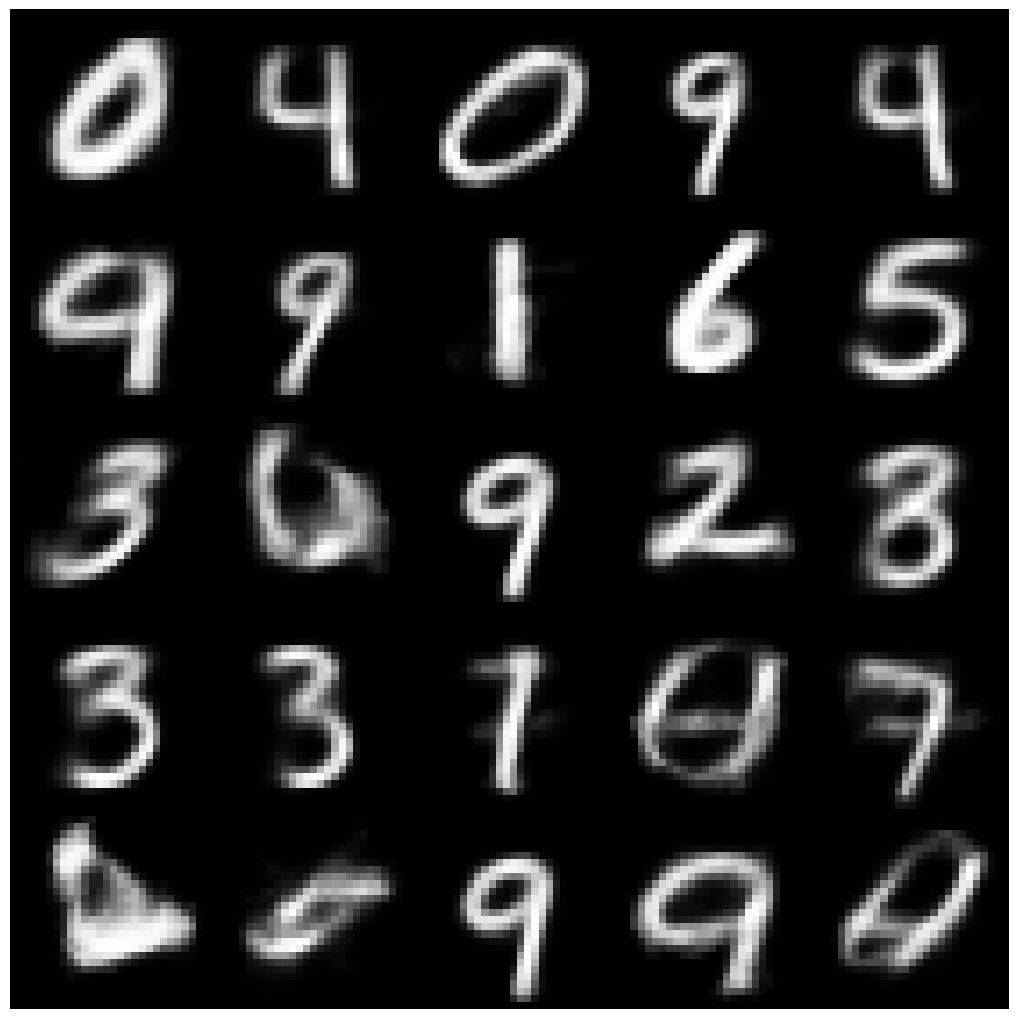

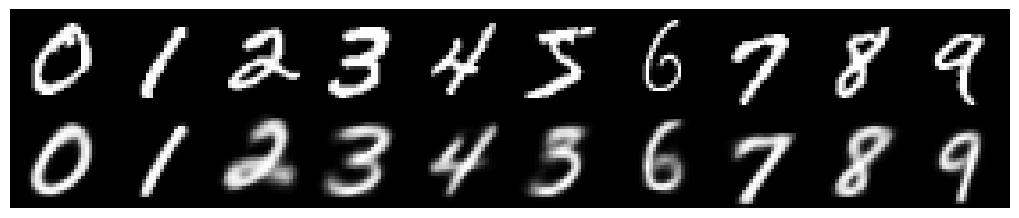

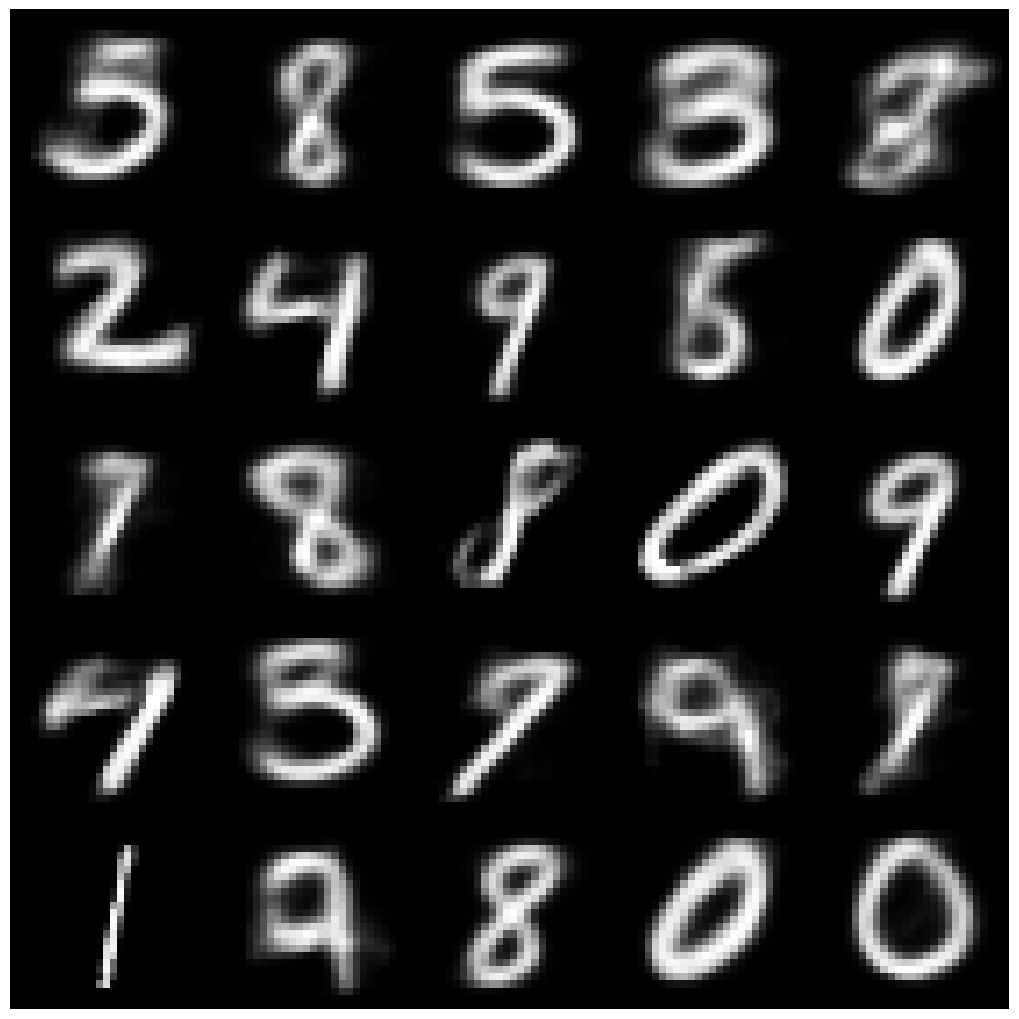

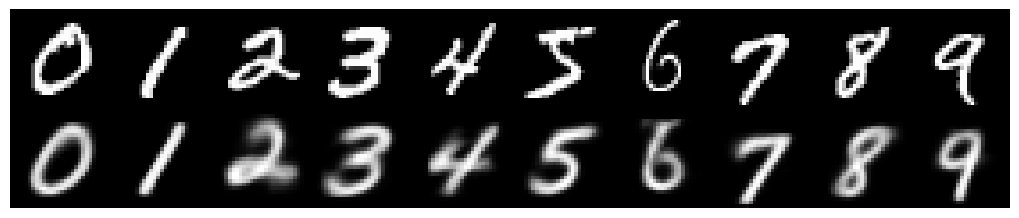

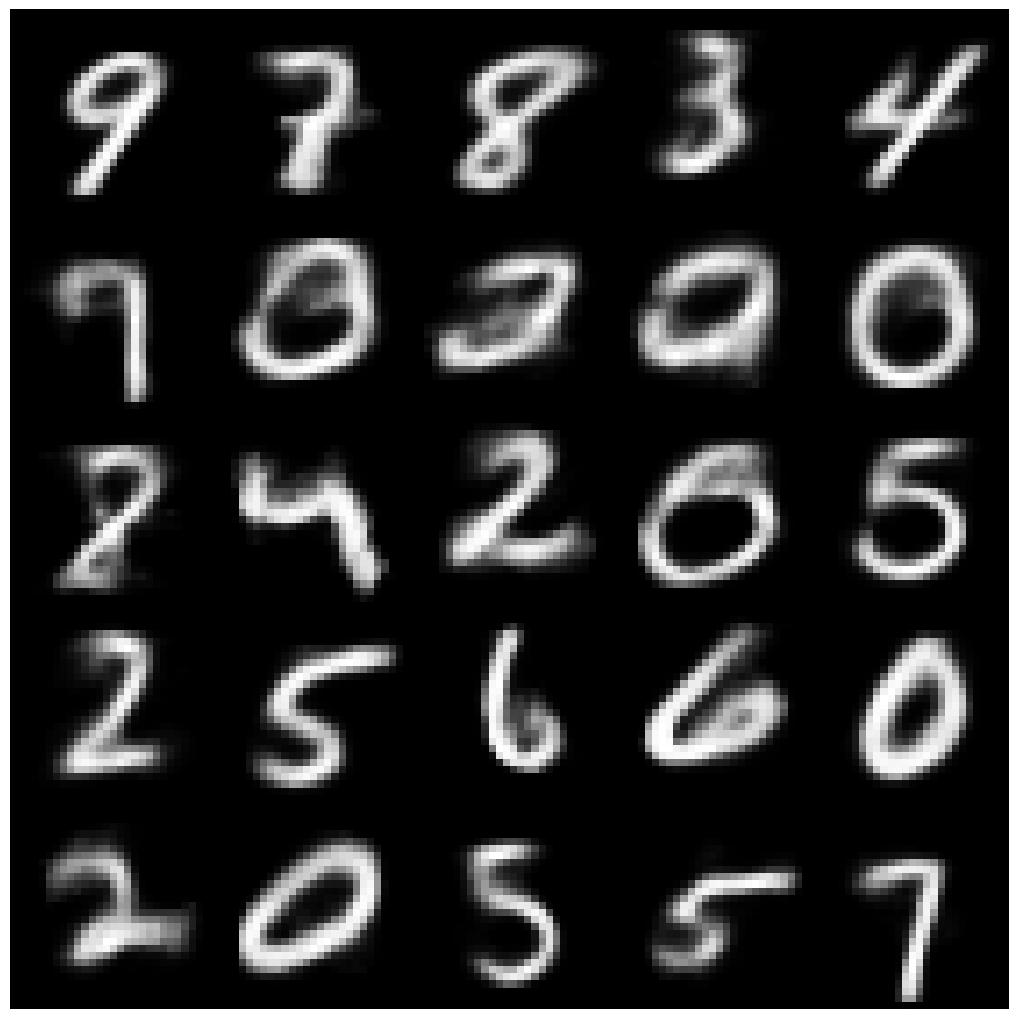

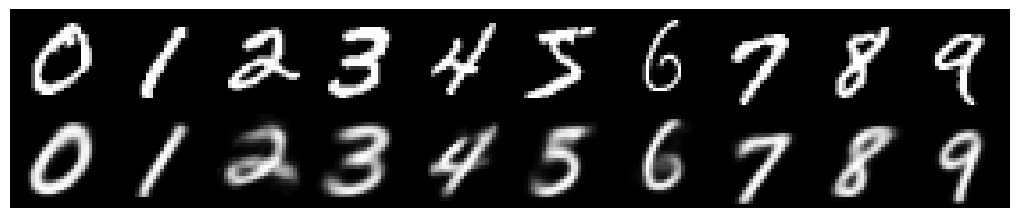

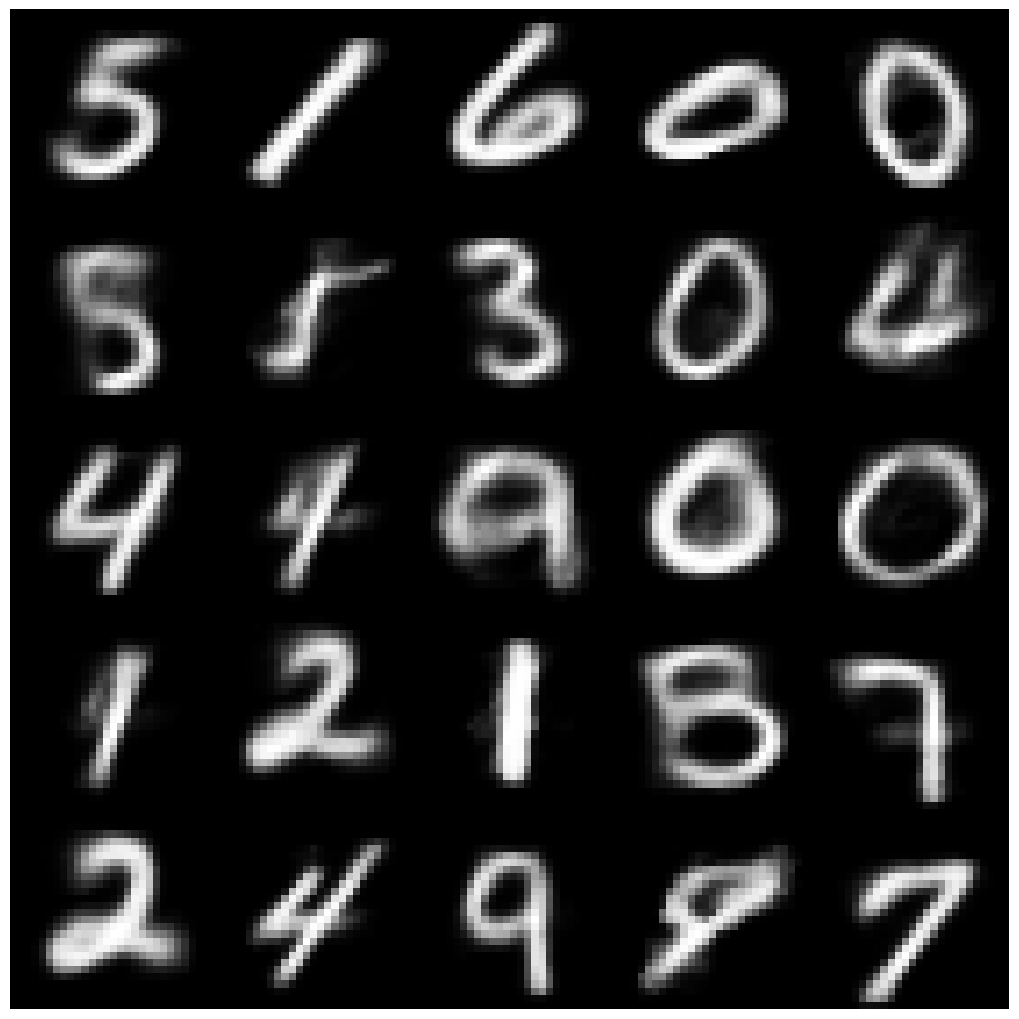

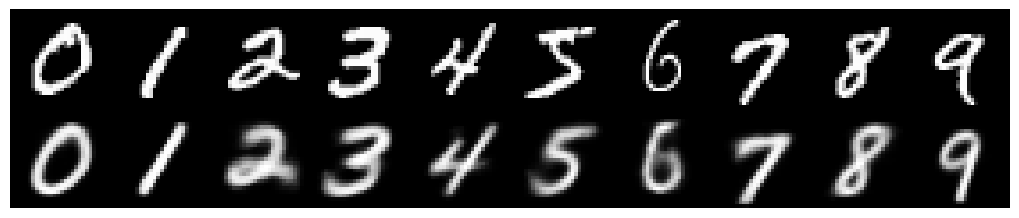

In [ ]:
wandb.agent(sweep_id, train, count=4)